<a href="https://colab.research.google.com/github/leolellisr/deep_learning_projects/blob/main/11_txt2img/01_P1_download_COCO_ds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
nome = "Leonardo de Lellis Rossi RA261900"
print(f'Meu nome é {nome}')

last = '220617_11h20'
print(f'Last update: {last}')

Meu nome é Leonardo de Lellis Rossi RA261900
Last update: 220617_11h20


Download dataset

# Projeto: text-to-image generation

## Importação de pacotes

In [ ]:
#!pip install webdataset

In [ ]:
import collections
import itertools
import functools
import math
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.utils.data as data

import numpy as np
from tqdm import tqdm_notebook
from tqdm import tqdm

import enum
import math

#import webdataset as wds  # pylint: disable=import-outside-toplevel

import os 
import os.path

import sys
from pycocotools.coco import COCO
import urllib
import zipfile 

from PIL import Image

import json
import pickle
from collections import Counter

## Parameters

In [ ]:
debug = True
checkinpoint = False
download_ds = True
save_in_drive = True

params = {
    'eval_every_steps': 10000,

    'lr': 3e-4,

    'batch_size': 128,
    'embedding_dim': 128,
    'hidden_size': 2*128,

    'image_size': 64,
    'num_channels': 192,
    'num_res_blocks': 3,
    'channel_mult': (1, 2, 3, 4),
    'num_heads': 1,
    'num_head_channels': 64,
    'num_heads_upsample': -1,
    'dropout': 0.1,
    'xf_width': 512,
    'diffusion_steps': 1000,

    'attention_resolutions': "32,16,8",

    't5_name': 't5-11b',
    'optimizer': 'Adam',
    'noise_schedule': "linear",
    'timestep_respacing': "",

    'aula': 'Project_P1',

    'path_saved_model': 'gdrive/MyDrive/Colab Notebooks/best_model_',
    'path_saved_datasets': 'gdrive/MyDrive/Colab Notebooks/ds_',
    
    'download_ds': False,
    'retrain': True,
    'use_scale_shift_norm': True,
    'resblock_updown': True,

    'cache_text_emb': False,
    'learn_sigma': True,
    'sigma_small': False,
    'predict_xstart': False,
    'rescale_timesteps': True,
    'rescale_learned_sigmas': True
}


In [ ]:
params['path_saved_model'] = params['path_saved_model']+params['aula']+'_IS'+str(params['image_size'])+'_BS'+str(params['batch_size'])+'_HS'+str(params['hidden_size'])+'_EmbDim'+str(params['embedding_dim'])+'.pt'
params['path_saved_model']

'gdrive/MyDrive/Colab Notebooks/best_model_Project_P1_IS64_BS128_HS256_EmbDim128.pt'

In [ ]:
print('num cuda', torch.cuda.device_count())

num cuda 0


In [ ]:
# Check which GPU we are using
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
def set_seeds():
  random.seed(123)
  np.random.seed(123)
  torch.manual_seed(123)
  torch.cuda.manual_seed(123)
set_seeds()

## Neptune config

In [ ]:
!pip install -U neptune-client


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 317 kB 5.4 MB/s 
     |████████████████████████████████| 829 kB 47.3 MB/s 
     |████████████████████████████████| 54 kB 2.6 MB/s 
     |████████████████████████████████| 181 kB 47.6 MB/s 
     |████████████████████████████████| 132 kB 45.8 MB/s 
     |████████████████████████████████| 79 kB 9.1 MB/s 
     |████████████████████████████████| 8.9 MB 37.2 MB/s 
     |████████████████████████████████| 138 kB 57.8 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 127 kB 60.8 MB/s 
     |████████████████████████████████| 130 kB 58.9 MB/s 
     |████████████████████████████████| 67 kB 6.4 MB/s 
     |████████████████████████████████| 64 kB 2.7 MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.16.3-py2.py3-none-any.whl size=570148 sha256=41c582bdbe6686577563f7cf01818e7ac4757a860d46ce4a6fd

In [ ]:
import neptune.new as neptune

In [ ]:
run = neptune.init(name= params['aula'], tags=[params['aula'], 'imagen', 'text-to-image generation', 'checkinpoint', 'text2img', 'COCO dataset'],
    project="leolellisr/dl-ia025",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1NjY1YmJkZi1hYmM5LTQ3M2QtOGU1ZC1iZTFlNWY4NjE1NDQifQ==",
)

https://app.neptune.ai/leolellisr/dl-ia025/e/DLIA-149


Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/you-should-know/what-can-you-log-and-display#hardware-consumption


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [ ]:
run['parameters'] = params

## Transformer

In [ ]:
# iremos utilizar a biblioteca dos transformers para ter acesso ao T5.
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |█▍                              | 194 kB 5.3 MB/s eta 0:00:01Warning: string series 'monitoring/stdout' value was longer than 1000 characters and was truncated. This warning is printed only once per series.
     |████████████████████████████████| 4.4 MB 5.3 MB/s 
     |████████████████████████████████| 6.6 MB 31.4 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 
     |████████████████████████████████| 596 kB 40.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import T5EncoderModel
from transformers import get_cosine_schedule_with_warmup
from transformers import AutoTokenizer

## COCO Dataset

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Download the Annotations and Captions :

In [ ]:
os.chdir( 'gdrive/MyDrive')

In [ ]:
if download_ds:
  os.makedirs('coco' , exist_ok=True)


In [ ]:
os.chdir( 'coco' )

In [ ]:
!git clone 'https://github.com/cocodataset/cocoapi.git'


### Extract Annotations from ZIP file

In [ ]:
if download_ds:
  os.chdir('cocoapi')

  # Download the annotation : 
  annotations_trainval2014 = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
  image_info_test2014 = 'http://images.cocodataset.org/annotations/image_info_test2014.zip'

  urllib.request.urlretrieve(annotations_trainval2014 , filename = 'annotations_trainval2014.zip' )
  urllib.request.urlretrieve(image_info_test2014 , filename= 'image_info_test2014.zip' )

  with zipfile.ZipFile('annotations_trainval2014.zip' , 'r') as zip_ref:
    zip_ref.extractall( 'cocoapi'  )  

  try:
    os.remove( 'annotations_trainval2014.zip' )
    print('zip removed')
  except:
    None

  with zipfile.ZipFile('image_info_test2014.zip' , 'r') as zip_ref:
    zip_ref.extractall( 'cocoapi'  )  

  try:
    os.remove( 'image_info_test2014.zip' )
    print('zip removed')
  except:
    None



### Initialize and verify the loaded data

In [ ]:
os.chdir('cocoapi')
os.chdir('annotations')


# initialize COCO API for instance annotations
dataType = 'val2014'
instances_annFile = 'instances_{}.json'.format(dataType)
print(instances_annFile)
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = 'captions_{}.json'.format(dataType)
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

instances_val2014.json
loading annotations into memory...
Done (t=9.54s)
creating index...
index created!
loading annotations into memory...
Done (t=1.22s)
creating index...
index created!


### plot a sample Image

In [ ]:
import matplotlib.pyplot as plt 
import skimage.io as io 
import numpy as np 
%matplotlib inline 

http://images.cocodataset.org/val2014/COCO_val2014_000000243946.jpg
Number of annotations i.e captions for the image:  [68740, 69688, 70813, 72226, 76717]

People fly kites and relax at a crowded sunlit beach.
A crowd of people flying kites on a beach.
A beach full of people and kite flyers.
A crowded beach is crowded with kites in the sky.
A sunny day on a public beach with many people enjoying different activities.


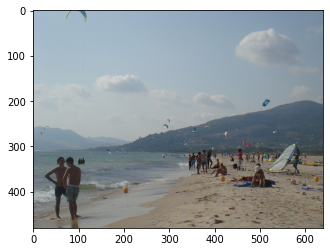

In [ ]:
#Pick a random annotation id and display img of that annotation  :
ann_id = np.random.choice( ids )
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs( img_id )[0]
url = img['coco_url']
print(url)
I = io.imread(url)
plt.imshow(I)

# Display captions for that annotation id :
ann_ids = coco_caps.getAnnIds( img_id   )
print('Number of annotations i.e captions for the image: ' , ann_ids)
print()
anns = coco_caps.loadAnns( ann_ids )
coco_caps.showAnns(anns)

## Download Train , Test , Val Images :

In [ ]:
if download_ds:
  os.chdir('..')

  train2014 = 'http://images.cocodataset.org/zips/train2014.zip'
  test2014 = 'http://images.cocodataset.org/zips/test2014.zip'
  val2014 = 'http://images.cocodataset.org/zips/val2014.zip'

  urllib.request.urlretrieve( train2014 , 'train2014' )
  urllib.request.urlretrieve( test2014 , 'test2014' )

('test2014', <http.client.HTTPMessage at 0x7fd434794f90>)

### unzip the download image zip files 

In [ ]:
if download_ds:
  with zipfile.ZipFile( 'train2014' , 'r' ) as zip_ref:
    zip_ref.extractall( 'images' )

  try:
    os.remove( 'train2014' )
    print('zip removed')
  except:
    None




In [ ]:
if download_ds:
  with zipfile.ZipFile( 'test2014' , 'r' ) as zip_ref:
    zip_ref.extractall( 'images' )

  try:
    os.remove( 'test2014' )
    print('zip removed')
  except:
    None

zip removed
